https://www.kaggle.com/c/lish-moa/overview

The Connectivity Map, a project within the Broad Institute of MIT and Harvard, together with the Laboratory for Innovation Science at Harvard (LISH), presents this challenge with the goal of advancing drug development through improvements to MoA prediction algorithms.

What is the Mechanism of Action (MoA) of a drug? And why is it important?

In the past, scientists derived drugs from natural products or were inspired by traditional remedies. Very common drugs, such as paracetamol, known in the US as acetaminophen, were put into clinical use decades before the biological mechanisms driving their pharmacological activities were understood. Today, with the advent of more powerful technologies, drug discovery has changed from the serendipitous approaches of the past to a more targeted model based on an understanding of the underlying biological mechanism of a disease. In this new framework, scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target. As a shorthand to describe the biological activity of a given molecule, scientists assign a label referred to as mechanism-of-action or MoA for short.

How do we determine the MoAs of a new drug?

One approach is to treat a sample of human cells with the drug and then analyze the cellular responses with algorithms that search for similarity to known patterns in large genomic databases, such as libraries of gene expression or cell viability patterns of drugs with known MoAs.

In this competition, you will have access to a unique dataset that combines gene expression and cell viability data. The data is based on a new technology that measures simultaneously (within the same samples) human cells’ responses to drugs in a pool of 100 different cell types (thus solving the problem of identifying ex-ante, which cell types are better suited for a given drug). In addition, you will have access to MoA annotations for more than 5,000 drugs in this dataset.

As is customary, the dataset has been split into testing and training subsets. Hence, your task is to use the training dataset to develop an algorithm that automatically labels each case in the test set as one or more MoA classes. Note that since drugs can have multiple MoA annotations, the task is formally a multi-label classification problem.

How to evaluate the accuracy of a solution?

Based on the MoA annotations, the accuracy of solutions will be evaluated on the average value of the logarithmic loss function applied to each drug-MoA annotation pair.

If successful, you’ll help to develop an algorithm to predict a compound’s MoA given its cellular signature, thus helping scientists advance the drug discovery process.

This notebook is a LightGBM model taking into account that there are a control group in our database. Moreover, we will perform PCA and try some new variables.\
All data analysis is donne in the "MoA data analysyis" notebook.\

In [1]:
import gc
import time
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA

import lightgbm as lgb

#Path to save the output
path_holdout = 'C:\\Users\\maxwi\\Python\\Kaggle\\Mechanism of action\\results 3\\'

In [2]:
#load the Data
train_features = pd.read_csv('train_features.csv')
train_targets_scored = pd.read_csv('train_targets_scored.csv')
test_features = pd.read_csv('test_features.csv')

In [3]:
#Function to reduce memory usage.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
def loss_train_validation(db, rotation_x, save_to):
    '''
    loss_train_validation(db = log_loss_hp, rotation_x = 0, save_to = save_file_final)
    '''
    #Plot train and validation log loss
    fig, ax = plt.subplots(figsize=(15, 10))
    #Train log loss:
    x = db['parameter']
    y = db['log_loss_train']

    ax.xaxis.set_ticks(x)
    ax.plot(x, y, color='black', zorder=1, linewidth=0.7, linestyle = 'solid')
    # add two layers of points to create an illusion of a discontinuous line. "zorder" specifies plotting order
    ax.scatter(x, y, s = 64, color = 'white', zorder = 2)
    ax.scatter(x, y, s = 8, color = 'black', zorder = 3)
    ax.text(x.iloc[-1] + 0.001, y.iloc[-1], 'Train', va = 'center')

    #Validation log loss:
#     x = log_loss_hp['parameter']
    y = db['log_loss_validation']

    ax.xaxis.set_ticks(x)
    ax.plot(x, y, color='black', zorder=1, linewidth=0.7, linestyle = 'dashed')
    # add two layers of points to create an illusion of a discontinuous line. "zorder" specifies plotting order
    ax.scatter(x, y, s=64, color='white', zorder=2)
    ax.scatter(x, y, s=8, color='black', zorder=3)
    ax.text(x.iloc[-1] + 0.001, y.iloc[-1], 'Validation', va = 'center')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.xticks(rotation = rotation_x)

    print()
    print('Smallest log loss:', round(db['log_loss_validation'].min(), 4))
    print('Smallest log loss parameter:', db[np.in1d(db['log_loss_validation'], db['log_loss_validation'].min())]['parameter'].values[0])
    log_loss_hp.to_csv(save_to, index = False)

In [5]:
train_features = reduce_mem_usage(train_features)
train_targets_scored = reduce_mem_usage(train_targets_scored)
test_features = reduce_mem_usage(test_features)

Mem. usage decreased to 40.18 Mb (74.8% reduction)
Mem. usage decreased to  4.86 Mb (87.1% reduction)
Mem. usage decreased to  6.72 Mb (74.8% reduction)


In [6]:
def print_time_to_end(progress_count, step_size, already_read, full_db_size):
    '''
    progress_check = print_time_to_end(progress_count = progress_check, step_size = progress_mult
                            , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))
    '''
#     progress += 1   #Changed to satisfy both situation if loading or not a saved progress.
    if already_read == progress_count * step_size:
        print()
        progress_per = round(already_read / full_db_size, 4)
        print(progress_per)
        
        end = time.time()
        elapsed = int(round(end - start, 0))
        total_run_time =  int(round(elapsed / (progress_per), 0))
        time_to_finish = int(round(elapsed / (progress_per), 0)) - elapsed
        print('Elapsed: {:02d}:{:02d}:{:02d}'.format(elapsed // 3600, (elapsed % 3600 // 60), elapsed % 60))
        print('Total run time: {:02d}:{:02d}:{:02d}'.format(total_run_time // 3600, (total_run_time % 3600 // 60), total_run_time % 60))
        print('Time to finish: {:02d}:{:02d}:{:02d}'.format(time_to_finish // 3600, (time_to_finish % 3600 // 60), time_to_finish % 60))
        print()
        return 1 #Increase progress_count
    
    return 0 #Don't increase progress_count

In [7]:
'''
Before start studying the variables, lets separate train_features and train_targets_scored into train_set and validation_set.
This is important to avoid overfitting.
'''
train_features_set, validation_features_set = train_test_split(train_features, test_size = 0.2, random_state = 1).copy()

train_labels_set = train_targets_scored.iloc[train_features_set.index].copy()
validation_labels_set = train_targets_scored.iloc[validation_features_set.index].copy()

#reset index. We don't really need a index as a number. We can identify our observations by the column 'sig_id'
train_features_set.reset_index(inplace = True)
train_features_set.drop('index', axis = 1, inplace = True)

validation_features_set.reset_index(inplace = True)
validation_features_set.drop('index', axis = 1, inplace = True)

train_labels_set.reset_index(inplace = True)
train_labels_set.drop('index', axis = 1, inplace = True)

validation_labels_set.reset_index(inplace = True)
validation_labels_set.drop('index', axis = 1, inplace = True)

C:\Users\maxwi\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
#Remove control observations.
train_features_without_control = train_features_set[train_features_set['cp_type'] != 'ctl_vehicle'].copy()
train_labels_without_control = train_labels_set.iloc[train_features_without_control.index].copy()

#reset index. 
train_features_without_control.reset_index(inplace = True)
train_features_without_control.drop('index', axis = 1, inplace = True)

train_labels_without_control.reset_index(inplace = True)
train_labels_without_control.drop('index', axis = 1, inplace = True)

In [9]:
'''
For the validation and test, we will remove just the column 'cp_type'.
However, we will not delete the observations. 
Instead, we will create a separate data frame with 'cp_type' so we can set all MoA equal to zero for these observations.
'''

validation_features_without_control = validation_features_set.drop(['cp_type'], axis = 1).copy()
validation_features_control = validation_features_set[['sig_id', 'cp_type']].copy()

test_features_without_control = test_features.drop(['cp_type'], axis = 1).copy()
test_features_control = test_features[['sig_id', 'cp_type']].copy()

To do the hyperparametrization and the holdout, we should use\
validation_features_without_control and validation_features_control, and\
test_features_without_control and test_features_control

In [10]:
#Lets start modeling!
#LightGBM

#Some adjustments so we can rum the lightGBM
train_x = train_features_without_control.drop(['sig_id', 'cp_type'], axis = 1).copy()
test_x = validation_features_without_control.drop(['sig_id'], axis = 1).copy()
test_x_control = validation_features_control.copy()
holdout_x = test_features_without_control.drop(['sig_id'], axis = 1).copy()
holdout_x_control = test_features_control.copy()

train_y = train_labels_without_control.drop(['sig_id'], axis = 1)
test_y = validation_labels_set.copy()


train_x['cp_dose'] = train_x['cp_dose'].str.extract(r"([1-2])", expand = True).astype(np.int8)
test_x['cp_dose'] = test_x['cp_dose'].str.extract(r"([1-2])", expand = True).astype(np.int8)

First, lets compare a model using PCA with 90% of the variables being explained by the components with a model without using PCA. Lets compare too using the is_unbalance option of LightGBM.

In [11]:
def PCA_train_variables(db_in, explained_percent):
    #Return the components that explain 'explained_percent' of the variance
    #, the number of 'g' components, and the number of 'c' components used to satisfy 'explained_percent'.
#Separate 'g' and 'c' variables.
    mask_g = db_in.columns.str.contains('^g-*')
    g_variables = db_in.loc[:,mask_g].copy()

    mask_c = db_in.columns.str.contains('^c-[0-99]')
    c_variables = db_in.loc[:,mask_c].copy()

    pca_g = PCA(n_components = explained_percent, random_state = 4) 
    pca_g.fit(g_variables)
    g_variables_pca = pd.DataFrame(data = pca_g.transform(g_variables))
    #Name columns:
    columns_name =[]
    for i in range(len(g_variables_pca.columns)):
        columns_name.append('g_pca_' + str(i + 1))
    g_variables_pca.columns = columns_name

    pca_c = PCA(n_components = explained_percent, random_state = 4) 
    pca_c.fit(c_variables)
    c_variables_pca = pd.DataFrame(data = pca_c.transform(c_variables))
    #Name columns:
    columns_name =[]
    for i in range(len(c_variables_pca.columns)):
        columns_name.append('c_pca_' + str(i + 1))
    c_variables_pca.columns = columns_name

    x_pca = db_in[['cp_time', 'cp_dose']]
    x_pca = x_pca.join(g_variables_pca)
    x_pca = x_pca.join(c_variables_pca)
    return x_pca, pca_g.n_components_, pca_c.n_components_

#For the validation and test database, we need to use the same number of components decided in the train database.
def PCA_validation_variables(db_in, n_components_g, n_components_c):

    mask_g = db_in.columns.str.contains('^g-*')
    g_variables = db_in.loc[:,mask_g].copy()

    mask_c = db_in.columns.str.contains('^c-[0-99]')
    c_variables = db_in.loc[:,mask_c].copy()

    pca_g = PCA(n_components = n_components_g, random_state = 4) 
    pca_g.fit(g_variables)
    g_variables_pca = pd.DataFrame(data = pca_g.transform(g_variables))
    #Name columns:
    columns_name =[]
    for i in range(len(g_variables_pca.columns)):
        columns_name.append('g_pca_' + str(i + 1))
    g_variables_pca.columns = columns_name

    pca_c = PCA(n_components = n_components_c, random_state = 4) 
    pca_c.fit(c_variables)
    c_variables_pca = pd.DataFrame(data = pca_c.transform(c_variables))
    #Name columns:
    columns_name =[]
    for i in range(len(c_variables_pca.columns)):
        columns_name.append('c_pca_' + str(i + 1))
    c_variables_pca.columns = columns_name

    x_pca = db_in[['cp_time', 'cp_dose']]
    x_pca = x_pca.join(g_variables_pca)
    x_pca = x_pca.join(c_variables_pca)
    return x_pca



train_x_pca, n_components_g, n_components_c = PCA_train_variables(train_x, 0.9)
test_x_pca = PCA_validation_variables(test_x, n_components_g, n_components_c)
holdout_x_pca = PCA_validation_variables(holdout_x, n_components_g, n_components_c)


0.8826
Elapsed: 00:08:02
Total run time: 00:09:06
Time to finish: 00:01:04


Smallest log loss: 0.016
Smallest log loss parameter: 5.0


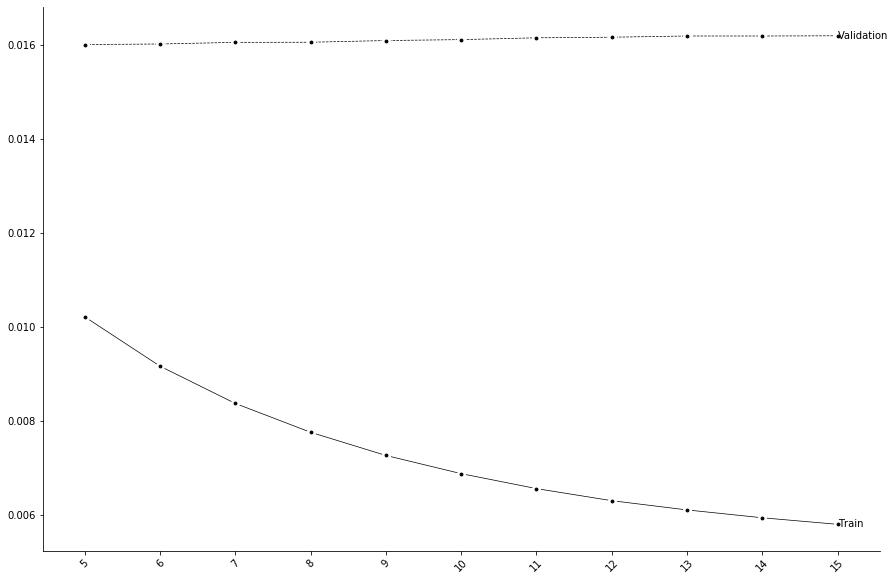

In [35]:
#Modeling without PCA and is_unbalance = False
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss

save_file_aux = path_holdout + "log_loss_num_leaves_without_pca_unbalance_false_aux.csv"
save_file_final = path_holdout + "log_loss_num_leaves_without_pca_unbalance_false_hp.csv"

#Load stoped process
log_loss_hp_aux = pd.read_csv(save_file_aux)
load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
# load_parameter = []  #If there isn't a file to load

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
                "is_unbalance": False,
#                 "max_depth": 4
            }

            features = train_x.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


0.4413
Elapsed: 00:04:29
Total run time: 00:10:10
Time to finish: 00:05:41


0.662
Elapsed: 00:17:34
Total run time: 00:26:32
Time to finish: 00:08:58


0.8826
Elapsed: 00:31:11
Total run time: 00:35:20
Time to finish: 00:04:09


Smallest log loss: 0.0194
Smallest log loss parameter: 5.0


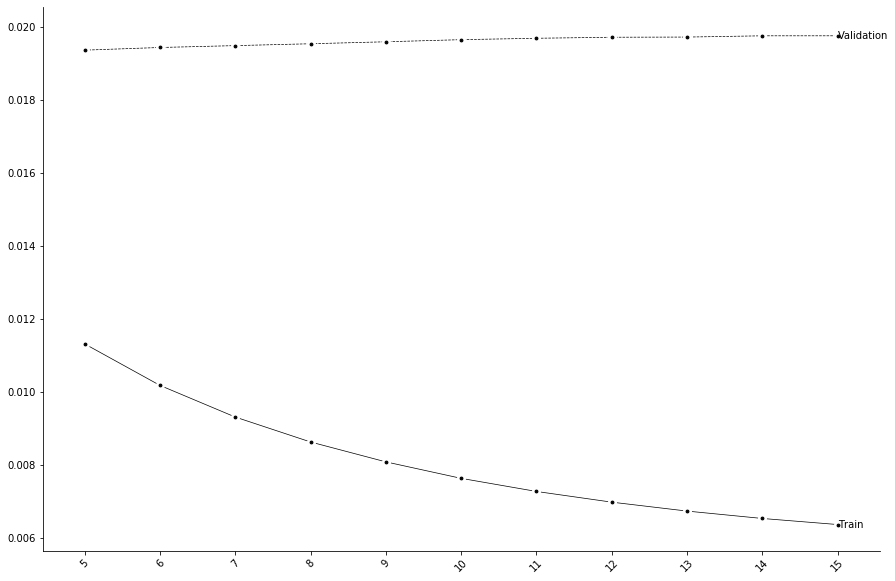

In [37]:
#Modeling with PCA and is_unbalance = False
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss

save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_aux.csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_hp.csv"

#Load stoped process
log_loss_hp_aux = pd.read_csv(save_file_aux)
load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
# load_parameter = []  #If there isn't a file to load

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
                "is_unbalance": False,
#                 "max_depth": 4
            }

            features = train_x_pca.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_pca, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_pca)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_pca)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_pca)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


Smallest log loss: 0.1274
Smallest log loss parameter: 14.0


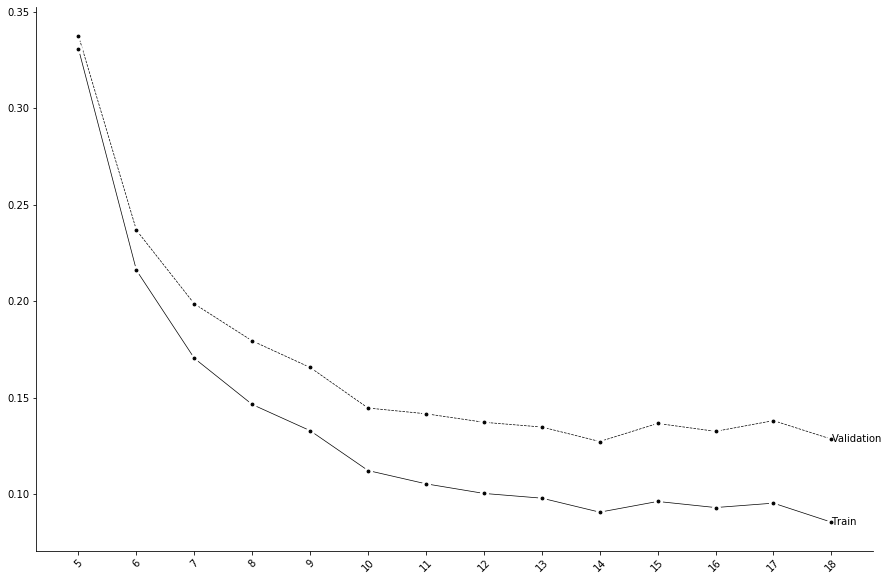

In [41]:
#Modeling without PCA and is_unbalance = True
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss

save_file_aux = path_holdout + "log_loss_num_leaves_without_pca_unbalance_true_aux.csv"
save_file_final = path_holdout + "log_loss_num_leaves_without_pca_unbalance_true_hp.csv"

#Load stoped process
log_loss_hp_aux = pd.read_csv(save_file_aux)
load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
# load_parameter = []  #If there isn't a file to load

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
                "is_unbalance": True,
#                 "max_depth": 4
            }

            features = train_x.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


Smallest log loss: 0.1601
Smallest log loss parameter: 17.0


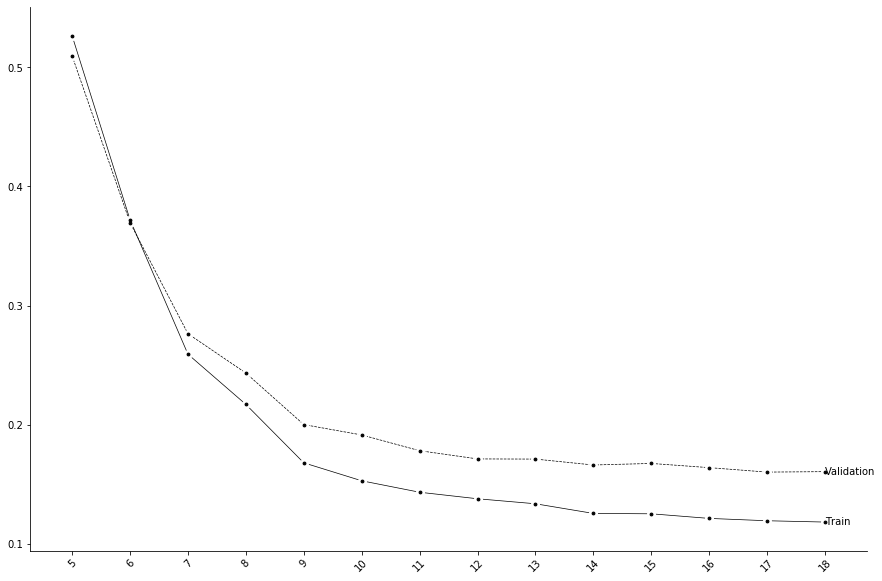

In [42]:
#Modeling with PCA and is_unbalance = True
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss

save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_unbalance_true_aux.csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_unbalance_true_hp.csv"

#Load stoped process
log_loss_hp_aux = pd.read_csv(save_file_aux)
load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
# load_parameter = []  #If there isn't a file to load

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
                "is_unbalance": True,
#                 "max_depth": 4
            }

            features = train_x_pca.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_pca, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_pca)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_pca)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_pca)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

As we can see, using the unbalanced option of LightGBM is not a good idea.
The PCA also increased our log loss.
However, lets see how much can we decrease the number of variables using PCA and without increasing too much the log loss. After that, we will try to create new variables. If we are successful creating new variables with PCA, we can recreate them without PCA.


0.4854
Elapsed: 00:08:18
Total run time: 00:17:06
Time to finish: 00:08:48


0.9709
Elapsed: 00:17:28
Total run time: 00:17:59
Time to finish: 00:00:31


Smallest log loss: 0.0191
Smallest log loss parameter: 3.0


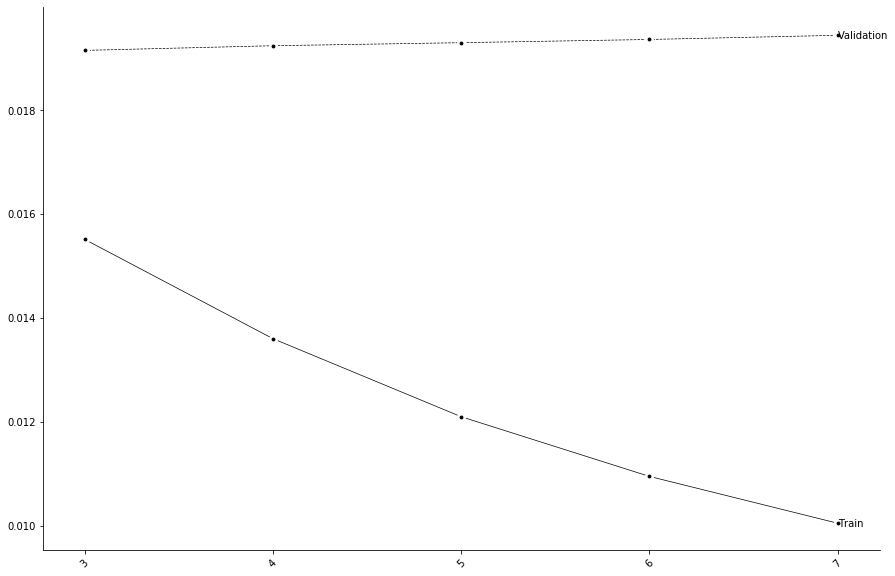

In [57]:
#Modeling with PCA 0.85
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss


pca_explained = 0.85
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_aux_" + str(pca_explained) + ".csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_hp_" + str(pca_explained) + ".csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


train_x_pca, n_components_g, n_components_c = PCA_train_variables(train_x, pca_explained)
test_x_pca = PCA_validation_variables(test_x, n_components_g, n_components_c)

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [3, 4, 5, 6, 7]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_pca.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_pca, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_pca)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_pca)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_pca)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


0.4854
Elapsed: 00:06:34
Total run time: 00:13:32
Time to finish: 00:06:58


0.9709
Elapsed: 00:13:46
Total run time: 00:14:11
Time to finish: 00:00:25


Smallest log loss: 0.0192
Smallest log loss parameter: 3.0


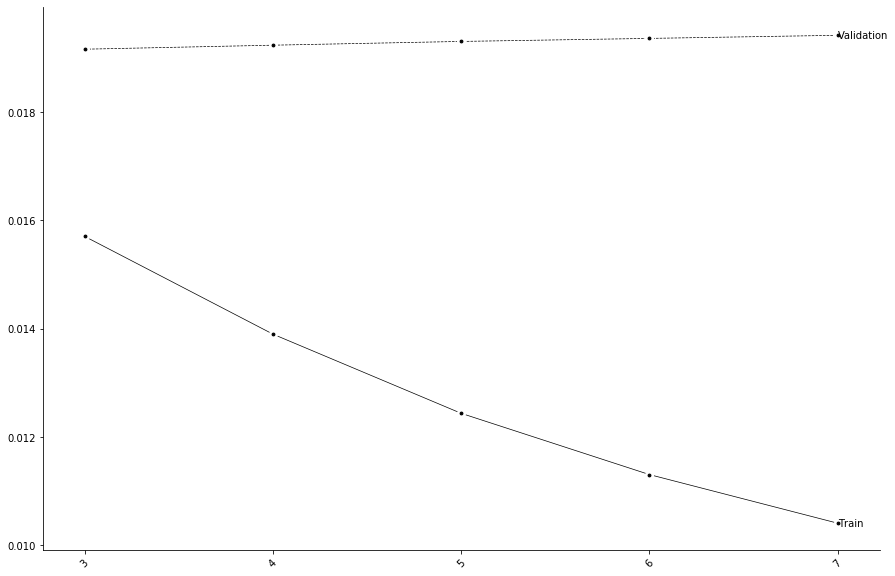

In [58]:
#Modeling with PCA 0.80
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss


pca_explained = 0.80
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_aux_" + str(pca_explained) + ".csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_hp_" + str(pca_explained) + ".csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


train_x_pca, n_components_g, n_components_c = PCA_train_variables(train_x, pca_explained)
test_x_pca = PCA_validation_variables(test_x, n_components_g, n_components_c)

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [3, 4, 5, 6, 7]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_pca.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_pca, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_pca)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_pca)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_pca)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


0.4854
Elapsed: 00:05:19
Total run time: 00:10:57
Time to finish: 00:05:38


0.9709
Elapsed: 00:11:04
Total run time: 00:11:24
Time to finish: 00:00:20


Smallest log loss: 0.0191
Smallest log loss parameter: 3.0


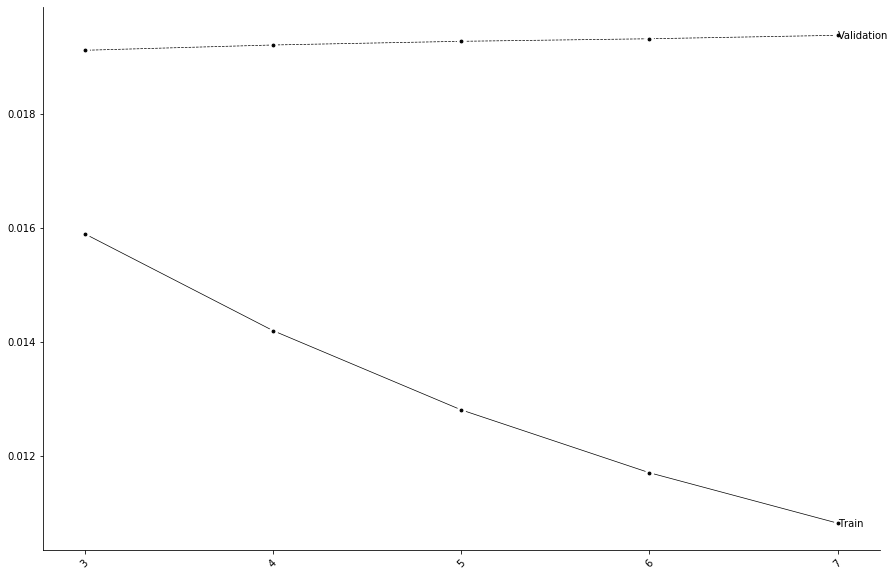

In [59]:
#Modeling with PCA 0.75
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss


pca_explained = 0.75
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_aux_" + str(pca_explained) + ".csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_hp_" + str(pca_explained) + ".csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


train_x_pca, n_components_g, n_components_c = PCA_train_variables(train_x, pca_explained)
test_x_pca = PCA_validation_variables(test_x, n_components_g, n_components_c)

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [3, 4, 5, 6, 7]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_pca.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_pca, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_pca)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_pca)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_pca)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


0.4854
Elapsed: 00:04:24
Total run time: 00:09:04
Time to finish: 00:04:40


0.9709
Elapsed: 00:09:14
Total run time: 00:09:31
Time to finish: 00:00:17


Smallest log loss: 0.0191
Smallest log loss parameter: 3.0


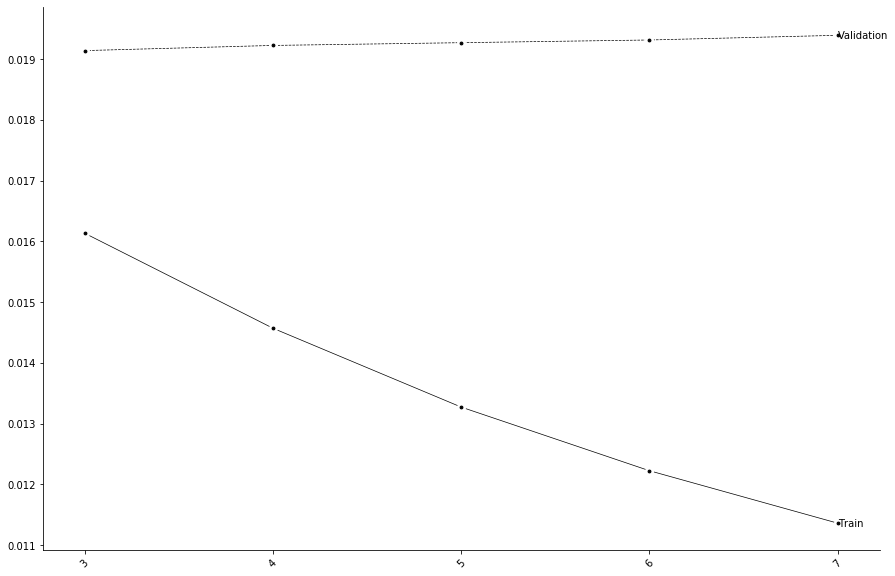

In [60]:
#Modeling with PCA 0.70
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss


pca_explained = 0.70
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_aux_" + str(pca_explained) + ".csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_hp_" + str(pca_explained) + ".csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


train_x_pca, n_components_g, n_components_c = PCA_train_variables(train_x, pca_explained)
test_x_pca = PCA_validation_variables(test_x, n_components_g, n_components_c)

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [3, 4, 5, 6, 7]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_pca.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_pca, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_pca)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_pca)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_pca)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


0.4854
Elapsed: 00:04:26
Total run time: 00:09:08
Time to finish: 00:04:42


0.9709
Elapsed: 00:09:14
Total run time: 00:09:31
Time to finish: 00:00:17


Smallest log loss: 0.0191
Smallest log loss parameter: 3.0


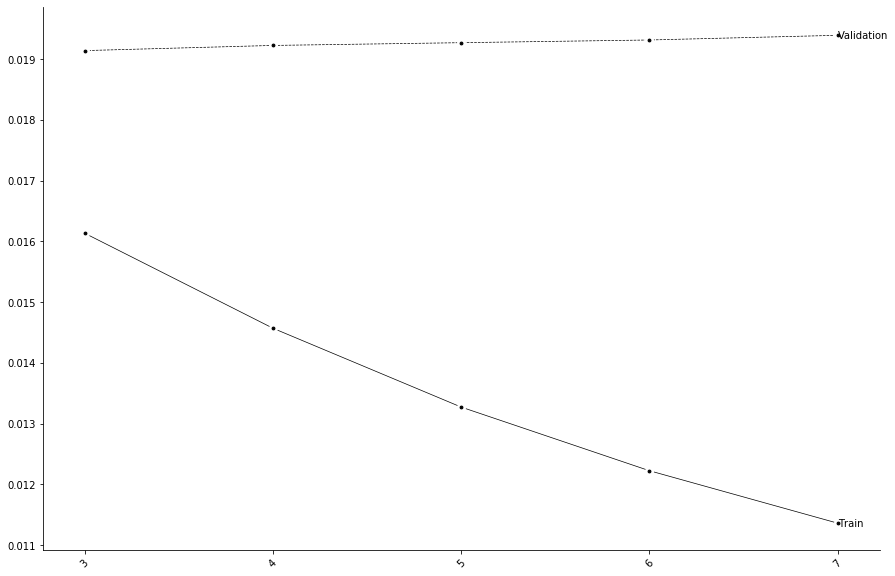

In [76]:
#Modeling with PCA 0.70
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss


pca_explained = 0.70
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_aux_" + str(pca_explained) + ".csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_hp_" + str(pca_explained) + ".csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


train_x_pca, n_components_g, n_components_c = PCA_train_variables(train_x, pca_explained)
test_x_pca = PCA_validation_variables(test_x, n_components_g, n_components_c)

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [3, 4, 5, 6, 7]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_pca.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_pca, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_pca)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_pca)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_pca)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


0.4854
Elapsed: 00:03:33
Total run time: 00:07:19
Time to finish: 00:03:46


0.9709
Elapsed: 00:07:27
Total run time: 00:07:40
Time to finish: 00:00:13


Smallest log loss: 0.0191
Smallest log loss parameter: 3.0


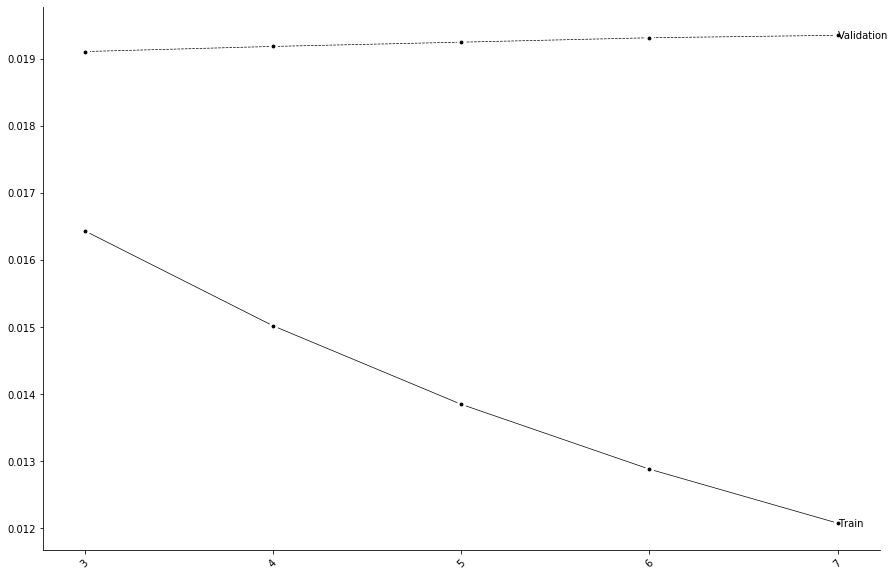

In [12]:
#Modeling with PCA 0.65
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss


pca_explained = 0.65
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_aux_" + str(pca_explained) + ".csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_hp_" + str(pca_explained) + ".csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


train_x_pca, n_components_g, n_components_c = PCA_train_variables(train_x, pca_explained)
test_x_pca = PCA_validation_variables(test_x, n_components_g, n_components_c)

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [3, 4, 5, 6, 7]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_pca.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_pca, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_pca)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_pca)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_pca)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

In [14]:
print('Components used:')
print('g variables:', n_components_g)
print('c variables:', n_components_c)

Components used:
g variables: 42
c variables: 1


Plotting tree:


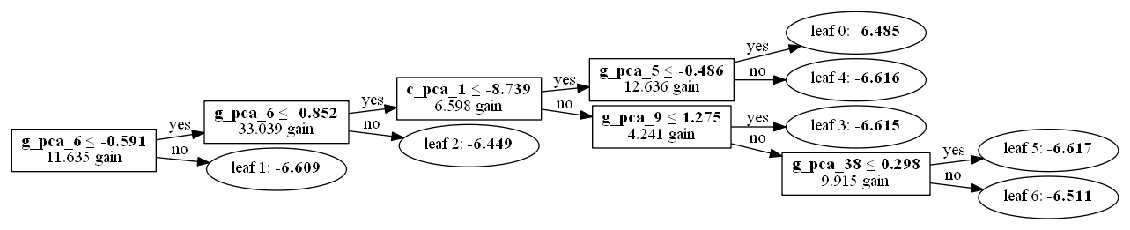

In [15]:
print('Plotting tree:')  # one tree use categorical feature to split
ax = lgb.plot_tree(model, figsize=(20, 20), show_info=['split_gain'])
plt.show()

We do not lose too much using just a few components of PCA.
Therefore, lets use 50 'g' components and '0 'c' components to develop new variables.


0.4045
Elapsed: 00:03:39
Total run time: 00:09:01
Time to finish: 00:05:22


0.8091
Elapsed: 00:07:42
Total run time: 00:09:31
Time to finish: 00:01:49


Smallest log loss: 0.019
Smallest log loss parameter: 2.0


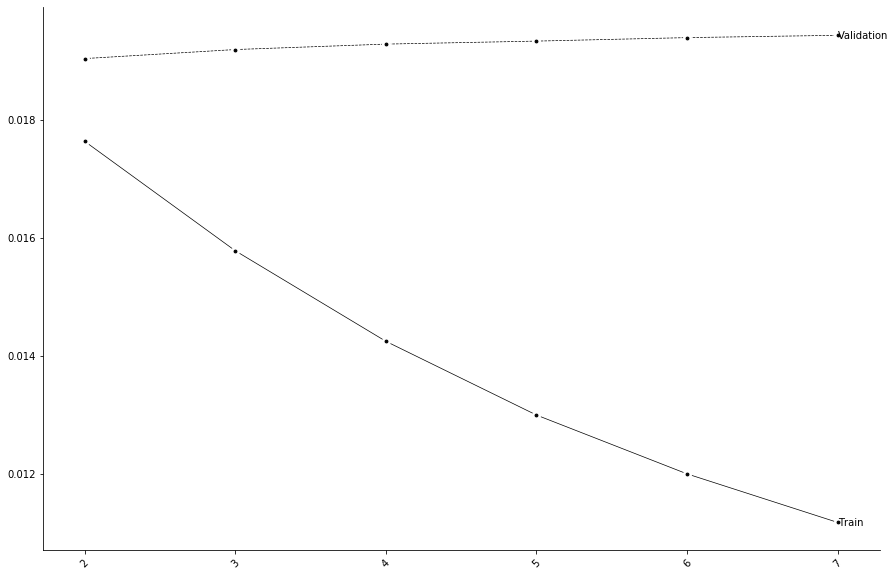

In [16]:
#First, lets run our benchmark.
#Modeling with PCA 
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss


n_components_g = 50
n_components_c = 10
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_aux_50_10.csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_unbalance_false_hp_50_10.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


train_x_pca = PCA_validation_variables(train_x, n_components_g, n_components_c)
test_x_pca = PCA_validation_variables(test_x, n_components_g, n_components_c)

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [2, 3, 4, 5, 6, 7]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_pca.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_pca, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_pca)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_pca)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_pca)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

It looks like our model is using only one variable. We need new variables!!

In [17]:
train_x_pca

,cp_time,cp_dose,g_pca_1,g_pca_2,g_pca_3,g_pca_4,g_pca_5,g_pca_6,g_pca_7,g_pca_8,...,c_pca_1,c_pca_2,c_pca_3,c_pca_4,c_pca_5,c_pca_6,c_pca_7,c_pca_8,c_pca_9,c_pca_10
0,48,1,-7.096084,2.606921,2.880736,0.616538,-1.114572,2.040437,-1.231792,6.419118,...,-3.210240,-0.245280,-0.008498,-0.414331,-0.139284,-0.240763,1.477892,1.123907,0.942913,-0.422775
1,24,2,-6.171826,0.390237,-5.782593,-7.515442,-3.910156,-4.384504,-1.754097,-5.724495,...,-3.640719,-0.919893,-0.427142,0.606985,-0.170237,0.158708,0.344216,-0.530744,-0.468677,-0.830027
2,24,1,-8.514978,0.553963,-0.745731,0.582141,0.218614,-1.738160,-2.014200,-3.830360,...,-5.525737,-0.146864,-0.733548,-1.293604,0.862513,-0.496759,0.198624,-0.387471,-0.670457,1.592410
3,72,1,94.861008,47.924035,-11.653345,-1.159554,-2.619867,-11.705756,23.765082,4.074945,...,91.137892,-4.944755,-8.763934,0.454032,1.019894,-1.035188,-0.849565,-0.130094,1.402958,1.120620
4,24,1,-4.927379,3.237693,1.755615,-7.321798,0.126914,-0.425036,-0.960685,4.624444,...,-3.914377,-0.386759,0.325991,-1.156067,-0.124606,0.744138,-0.457593,-0.787472,-0.309213,-0.299875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17571,72,1,-10.089786,-0.356532,-0.329180,-8.388546,-1.184869,-5.509330,0.924393,-11.451140,...,-9.109160,-0.388978,1.100173,-0.826942,0.149058,-0.731026,0.646163,0.265992,0.472969,-0.079078
17572,24,1,-6.324851,1.082471,-1.337350,-3.315758,0.444332,-0.432177,-1.276308,2.030109,...,-4.412575,-0.900036,0.110440,-0.334466,0.412165,0.616151,-0.327485,-0.012834,0.597422,0.550518
17573,48,1,-10.493762,1.157490,3.904065,-1.972689,1.491613,0.411249,0.211799,1.114599,...,-1.889653,-1.072010,-0.647839,-0.014942,-0.693299,-0.240903,0.928339,0.687549,0.239499,-1.481217
17574,48,2,-7.751496,-0.096790,-0.991060,-1.876081,-1.986746,0.765337,-1.001448,1.844558,...,-1.976038,-0.636358,-0.147025,-0.118705,-0.239832,0.362294,0.374453,0.229002,1.005660,-0.204412


First lets multiply all 'g' and 'c' variables by cp_dose, after we will divide them and see witch one is better for our model.


0.4045
Elapsed: 00:04:48
Total run time: 00:11:52
Time to finish: 00:07:04


0.8091
Elapsed: 00:10:12
Total run time: 00:12:36
Time to finish: 00:02:24


Smallest log loss: 0.0191
Smallest log loss parameter: 2.0


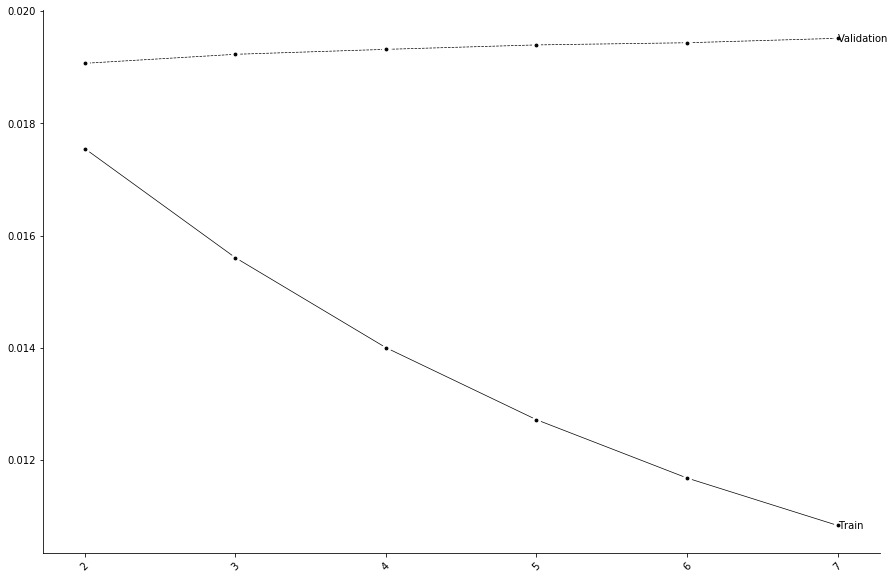

In [27]:
mask_g_c = train_x_pca.columns.str.contains('^g_*|^c_')
g_c_variables = train_x_pca.loc[:,mask_g_c].columns

train_x_pca_mult_dose = train_x_pca.copy()
for col in g_c_variables:
    train_x_pca_mult_dose['mult_' + col] = train_x_pca_mult_dose['cp_dose']*train_x_pca_mult_dose[col]

test_x_pca_mult_dose = test_x_pca.copy()
for col in g_c_variables:
    test_x_pca_mult_dose['mult_' + col] = test_x_pca_mult_dose['cp_dose']*test_x_pca_mult_dose[col]
    
    
#Modeling with PCA 
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss

train_x_lgbm = train_x_pca_mult_dose.copy()
test_x_lgbm = test_x_pca_mult_dose.copy()
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_aux_50_10_mult_dose.csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_hp_50_10_mult_dose.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [2, 3, 4, 5, 6, 7]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_lgbm.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_lgbm, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_lgbm)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_lgbm)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_lgbm)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Plotting tree:


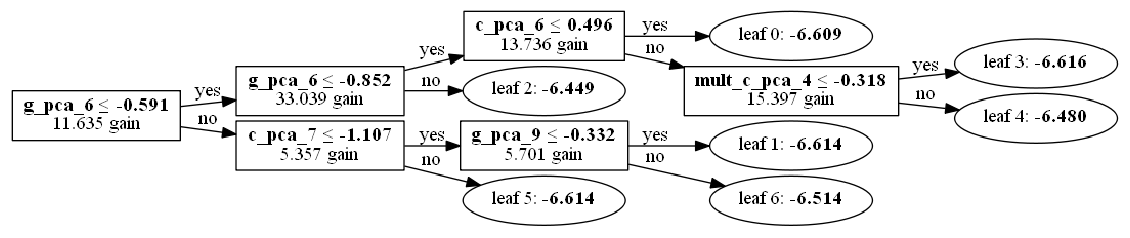

In [28]:
print('Plotting tree:')  # one tree use categorical feature to split
ax = lgb.plot_tree(model, figsize=(20, 20), show_info=['split_gain'])
plt.show()

Multiplying all our variables by the dosage did not change our final model that would use only two leaves.\
Lets try dividing it.


0.4045
Elapsed: 00:04:51
Total run time: 00:11:59
Time to finish: 00:07:08


0.8091
Elapsed: 00:10:16
Total run time: 00:12:41
Time to finish: 00:02:25


Smallest log loss: 0.0191
Smallest log loss parameter: 2.0


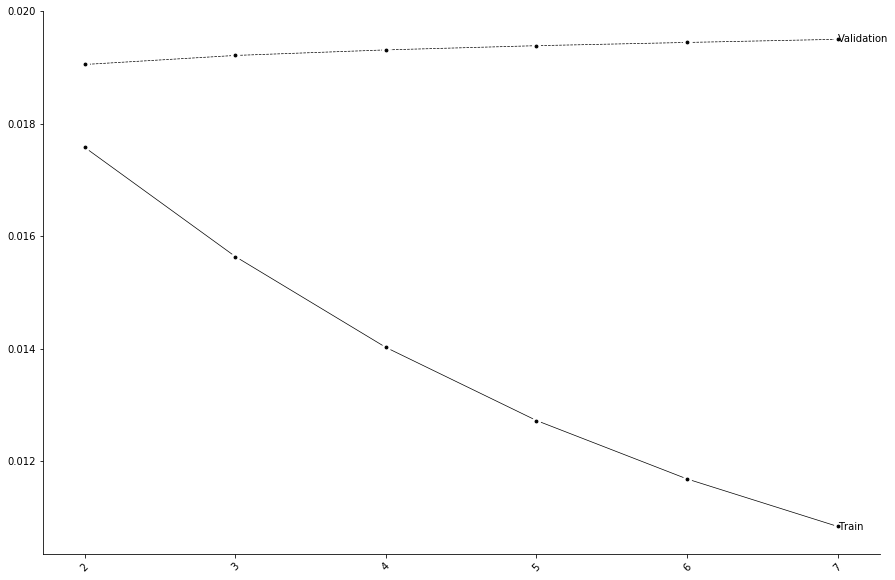

In [35]:
train_x_pca_div_dose = train_x_pca.copy()
for col in g_c_variables:
    train_x_pca_div_dose['div_' + col] = train_x_pca_div_dose[col]/train_x_pca_div_dose['cp_dose']

test_x_pca_div_dose = test_x_pca.copy()
for col in g_c_variables:
    test_x_pca_div_dose['div_' + col] = test_x_pca_div_dose[col]/test_x_pca_div_dose['cp_dose']
    
    
#Modeling with PCA 
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss

train_x_lgbm = train_x_pca_div_dose.copy()
test_x_lgbm = test_x_pca_div_dose.copy()
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_aux_50_10_div_dose.csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_hp_50_10_div_dose.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [2, 3, 4, 5, 6, 7]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_lgbm.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_lgbm, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_lgbm)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_lgbm)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_lgbm)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Plotting tree:


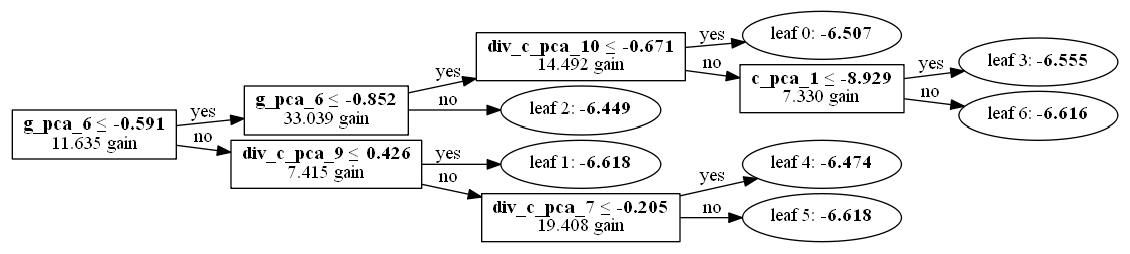

In [36]:
print('Plotting tree:')  # one tree use categorical feature to split
ax = lgb.plot_tree(model, figsize=(20, 20), show_info=['split_gain'])
plt.show()

The log loss did not decreased, but some of the divided variables become more important then the normal ones.\
Instead of dividing, lets multiply by some factor when the dosage is 1.


0.4045
Elapsed: 00:04:50
Total run time: 00:11:57
Time to finish: 00:07:07


0.8091
Elapsed: 00:10:16
Total run time: 00:12:41
Time to finish: 00:02:25


Smallest log loss: 0.0191
Smallest log loss parameter: 2.0


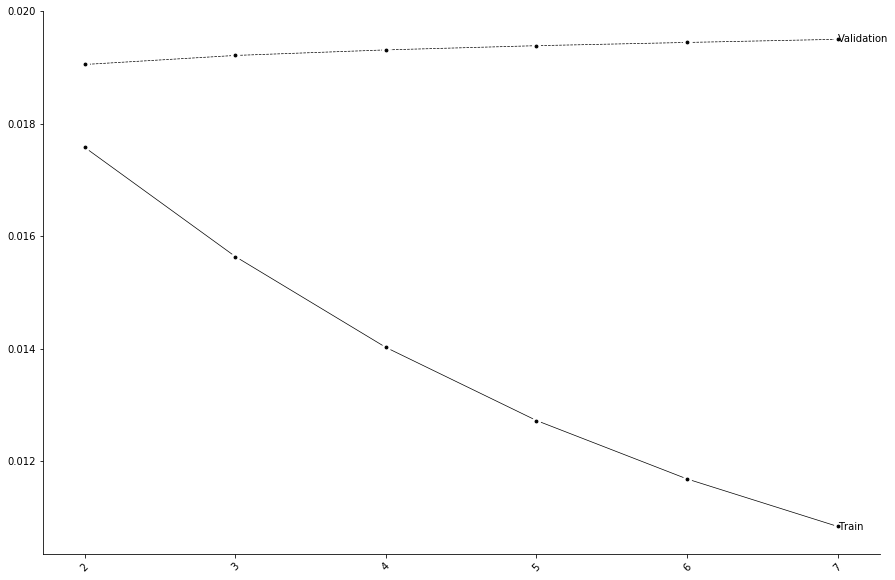

In [41]:
train_x_pca_mult_fact_2_dose = train_x_pca.copy()
for col in g_c_variables:
    train_x_pca_mult_fact_2_dose['mult_fact_2_' + col] = train_x_pca_mult_fact_2_dose.apply(
        lambda row: row[col] if row['cp_dose'] == 2 else row[col] * 2, axis = 1)
    
test_x_pca_mult_fact_2_dose = test_x_pca.copy()
for col in g_c_variables:    
    test_x_pca_mult_fact_2_dose['mult_fact_2_' + col] = test_x_pca_mult_fact_2_dose.apply(
        lambda row: row[col] if row['cp_dose'] == 2 else row[col] * 2, axis = 1)
    
    
#Modeling with PCA 
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss

train_x_lgbm = train_x_pca_mult_fact_2_dose.copy()
test_x_lgbm = test_x_pca_mult_fact_2_dose.copy()
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_aux_50_10_mult_fact_2_dose.csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_hp_50_10_mult_fact_2_dose.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [2, 3, 4, 5, 6, 7]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_lgbm.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_lgbm, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_lgbm)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_lgbm)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_lgbm)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Plotting tree:


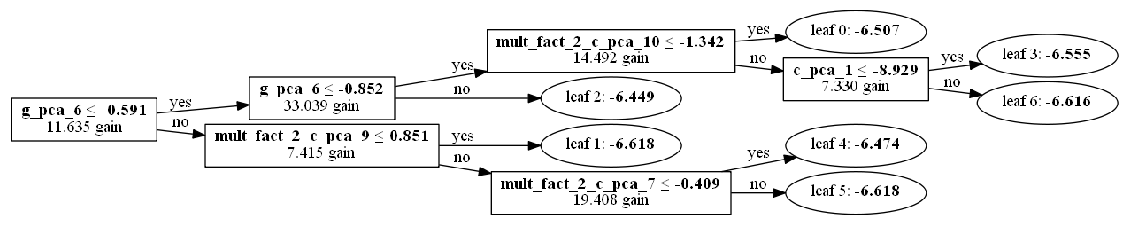

In [42]:
print('Plotting tree:')  # one tree use categorical feature to split
ax = lgb.plot_tree(model, figsize=(20, 20), show_info=['split_gain'])
plt.show()

The result of multiplicating by 2 when the dosage is 2 had the same effect of the division. The multiplication is preferable because it will be easier to make new variables with dosage and duration.\
Before using the duration variable, lets try to change the multiplication facor of 2 by 1.5.


0.4045
Elapsed: 00:04:49
Total run time: 00:11:54
Time to finish: 00:07:05


0.8091
Elapsed: 00:10:17
Total run time: 00:12:43
Time to finish: 00:02:26


Smallest log loss: 0.019
Smallest log loss parameter: 2.0


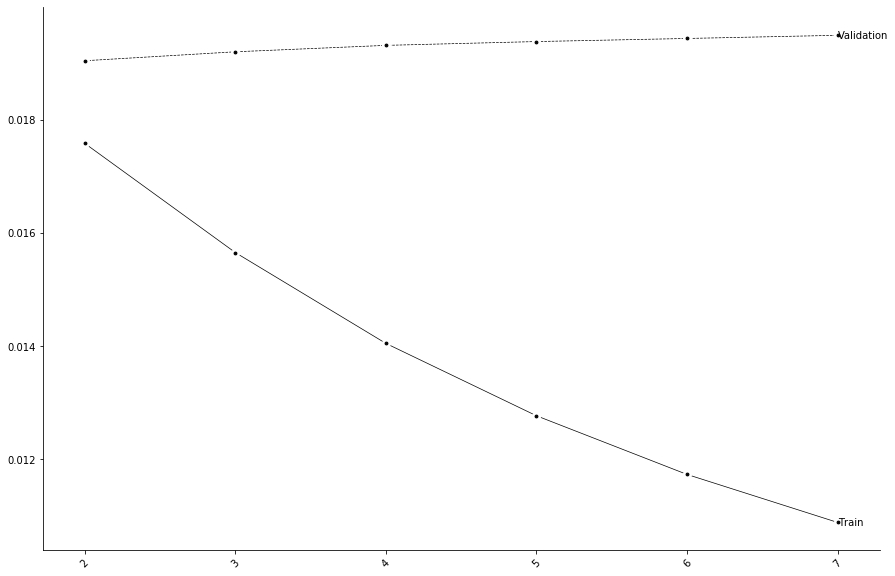

In [43]:
train_x_pca_mult_fact_15_dose = train_x_pca.copy()
for col in g_c_variables:
    train_x_pca_mult_fact_15_dose['mult_fact_15_' + col] = train_x_pca_mult_fact_15_dose.apply(
        lambda row: row[col] if row['cp_dose'] == 2 else row[col] * 1.5, axis = 1)
    
test_x_pca_mult_fact_15_dose = test_x_pca.copy()
for col in g_c_variables:    
    test_x_pca_mult_fact_15_dose['mult_fact_15' + col] = test_x_pca_mult_fact_15_dose.apply(
        lambda row: row[col] if row['cp_dose'] == 2 else row[col] * 1.5, axis = 1)
    
    
#Modeling with PCA 
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss

train_x_lgbm = train_x_pca_mult_fact_15_dose.copy()
test_x_lgbm = test_x_pca_mult_fact_15_dose.copy()
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_aux_50_10_mult_fact_15_dose.csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_hp_50_10_mult_fact_15_dose.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [2, 3, 4, 5, 6, 7]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_lgbm.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_lgbm, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_lgbm)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_lgbm)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_lgbm)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Plotting tree:


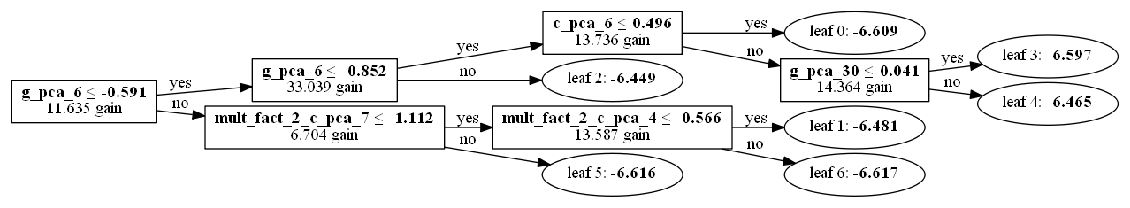

In [44]:
print('Plotting tree:')  # one tree use categorical feature to split
ax = lgb.plot_tree(model, figsize=(20, 20), show_info=['split_gain'])
plt.show()

Changing the multiplication factor did not help.\
One htng important to notice is that these transformations just affect the 'c' variables and not the 'g' ones.\
Lets now work with cp_time.


0.4045
Elapsed: 00:05:00
Total run time: 00:12:22
Time to finish: 00:07:22


0.8091
Elapsed: 00:10:27
Total run time: 00:12:55
Time to finish: 00:02:28


Smallest log loss: 0.019
Smallest log loss parameter: 2.0


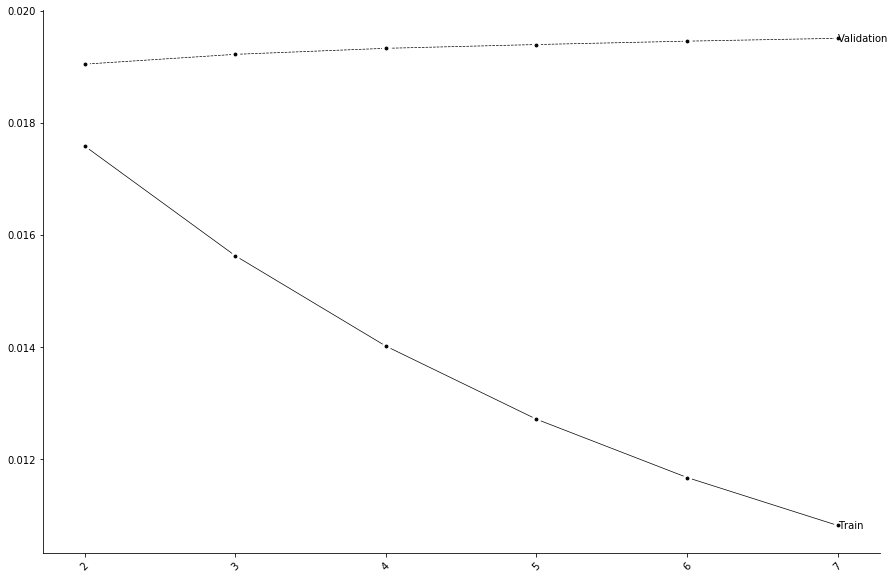

In [47]:
#We divided cp_time by 24 to represent 1, 2 or 3 days of duration.
train_x_pca_mult_time = train_x_pca.copy()
for col in g_c_variables:
    train_x_pca_mult_time['mult_' + col] = train_x_pca_mult_time[col] * (train_x_pca_mult_time['cp_time']/24)

test_x_pca_mult_time = test_x_pca.copy()
for col in g_c_variables:
    test_x_pca_mult_time['mult_' + col] = test_x_pca_mult_time[col] * (test_x_pca_mult_time['cp_time']/24)
    
    
#Modeling with PCA 
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss

train_x_lgbm = train_x_pca_mult_time.copy()
test_x_lgbm = test_x_pca_mult_time.copy()
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_aux_50_10_mult_time.csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_hp_50_10_mult_time.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [2, 3, 4, 5, 6, 7]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_lgbm.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_lgbm, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_lgbm)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_lgbm)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_lgbm)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Plotting tree:


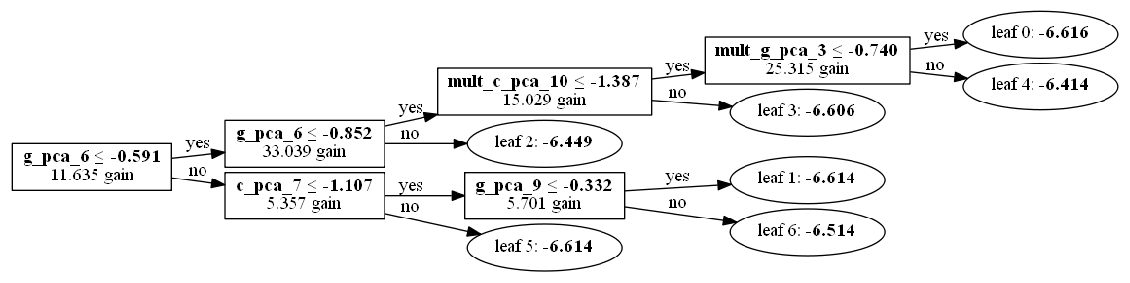

In [48]:
print('Plotting tree:')  # one tree use categorical feature to split
ax = lgb.plot_tree(model, figsize=(20, 20), show_info=['split_gain'])
plt.show()


0.4045
Elapsed: 00:04:52
Total run time: 00:12:02
Time to finish: 00:07:10


0.8091
Elapsed: 00:10:21
Total run time: 00:12:48
Time to finish: 00:02:27


Smallest log loss: 0.019
Smallest log loss parameter: 2.0


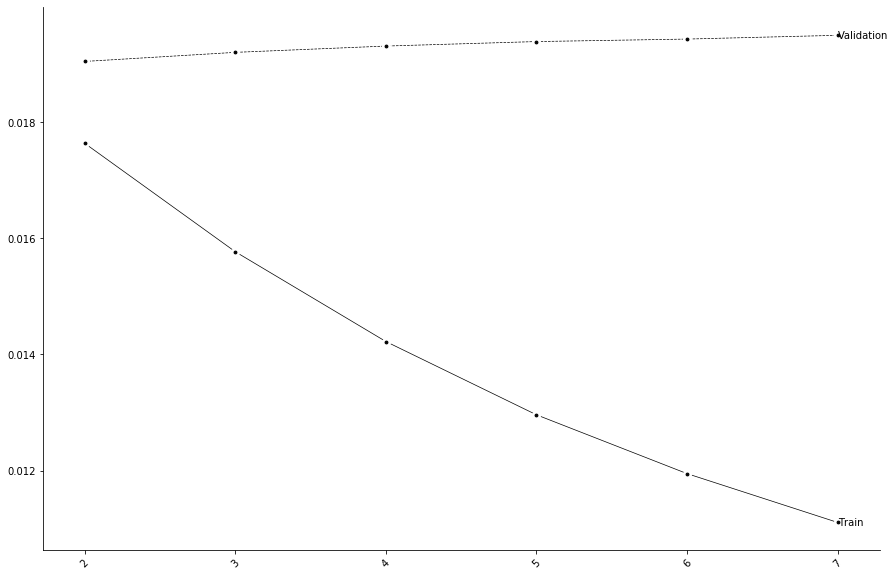

In [49]:
train_x_pca_mult_fact_time = train_x_pca.copy()
for col in g_c_variables:
    train_x_pca_mult_fact_time['mult_fact_' + col] = train_x_pca_mult_fact_time.apply(
        lambda row: row[col] if row['cp_time'] == 3 else (
            row[col] * 2 if row['cp_time'] == 2 else row[col] * 3), axis = 1)
    
test_x_pca_mult_fact_time = test_x_pca.copy()
for col in g_c_variables:    
    test_x_pca_mult_fact_time['mult_fact_' + col] = test_x_pca_mult_fact_time.apply(
        lambda row: row[col] if row['cp_time'] == 3 else (
            row[col] * 2 if row['cp_time'] == 2 else row[col] * 3), axis = 1)
    
    
#Modeling with PCA 
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss

train_x_lgbm = train_x_pca_mult_fact_time.copy()
test_x_lgbm = test_x_pca_mult_fact_time.copy()
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_aux_50_10_mult_fact_time.csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_hp_50_10_mult_fact_time.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [2, 3, 4, 5, 6, 7]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_lgbm.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_lgbm, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_lgbm)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_lgbm)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_lgbm)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Plotting tree:


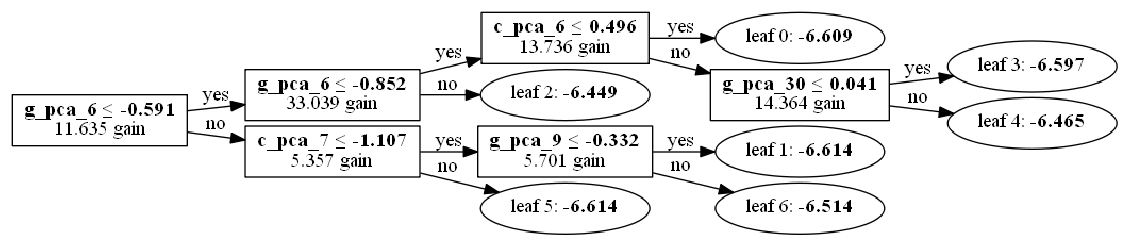

In [50]:
print('Plotting tree:')  # one tree use categorical feature to split
ax = lgb.plot_tree(model, figsize=(20, 20), show_info=['split_gain'])
plt.show()

Multiplying the 'g' and 'c' by the duration did not decrease the log loss, but this time the 'g' variables were also affected.\
Lets first make a model using the new variables with dosage and duration in the same model. After, lets do new variables combining dosage and duration.


0.2697
Elapsed: 00:05:36
Total run time: 00:20:46
Time to finish: 00:15:10


0.5394
Elapsed: 00:11:59
Total run time: 00:22:13
Time to finish: 00:10:14


0.8091
Elapsed: 00:18:53
Total run time: 00:23:20
Time to finish: 00:04:27


Smallest log loss: 0.0191
Smallest log loss parameter: 2.0


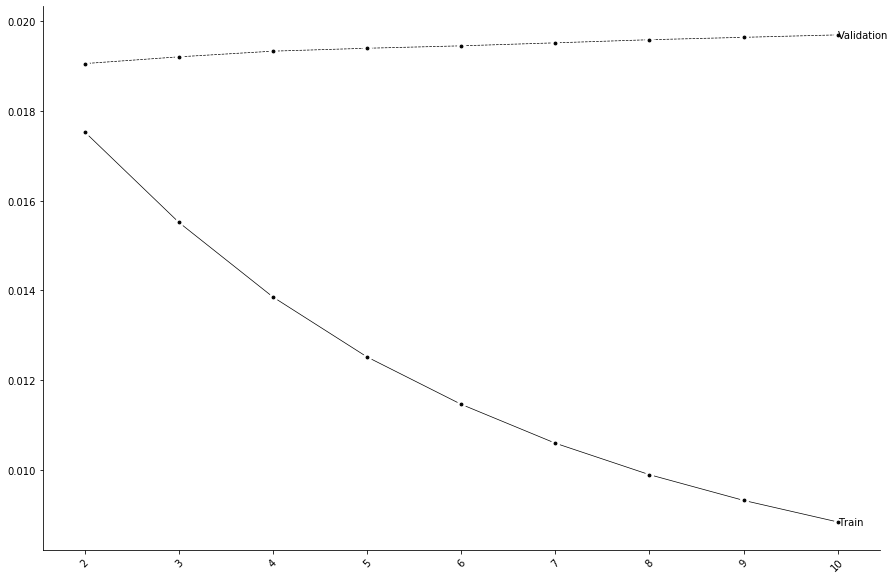

In [102]:
#Join the new variables
mask_g_c_extract = train_x_pca.columns.str.extract('(^g_pca_[1-9]?[0-9]|^c_pca_[1-9]?[0-9])')[0]
mask_g_c_extract.dropna(inplace = True)  #used to drop common variables

train_mult_fact_2_dose = train_x_pca_mult_fact_2_dose.drop(['cp_time','cp_dose'], axis = 1).copy()
test_mult_fact_2_dose = test_x_pca_mult_fact_2_dose.drop(['cp_time','cp_dose'], axis = 1).copy()

train_mult_time = train_x_pca_mult_time.drop(['cp_time','cp_dose'], axis = 1).copy()
train_mult_time = train_mult_time.drop(mask_g_c_extract, axis = 1).copy()
test_mult_time = test_x_pca_mult_time.drop(['cp_time','cp_dose'], axis = 1).copy()
test_mult_time = test_mult_time.drop(mask_g_c_extract, axis = 1).copy()

train_dose_time_sep = train_mult_fact_2_dose.join(train_mult_time)
test_dose_time_sep = test_mult_fact_2_dose.join(test_mult_time)

    
    
#Modeling with PCA 
from sklearn.metrics import log_loss

train_x_lgbm = train_dose_time_sep.copy()
test_x_lgbm = test_dose_time_sep.copy()
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_aux_50_10_dose_time_sep.csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_hp_50_10_dose_time_sep.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_lgbm.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_lgbm, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_lgbm)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_lgbm)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_lgbm)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Plotting tree:


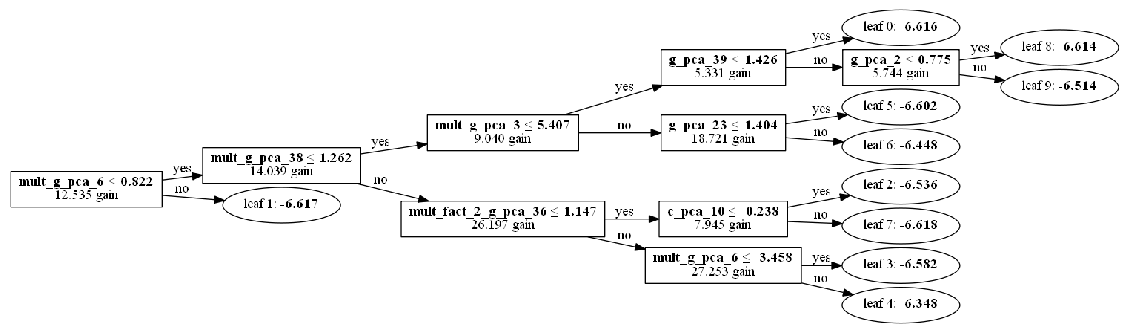

In [104]:
print('Plotting tree:')  # one tree use categorical feature to split
ax = lgb.plot_tree(model, figsize=(20, 25), show_info=['split_gain'])
plt.show()

In [107]:
print('Saving tree in a pdf') #for a better view.
graph = lgb.create_tree_digraph(model)
graph.render(view=True)

Saving tree in a pdf


'Digraph.gv.pdf'

We did not achieved a better log loss but the new variables where used by the model.\
Lets now make a new varible considering the dosage and the duration at the same time.


0.2697
Elapsed: 00:04:30
Total run time: 00:16:41
Time to finish: 00:12:11


0.5394
Elapsed: 00:09:32
Total run time: 00:17:40
Time to finish: 00:08:08


0.8091
Elapsed: 00:14:58
Total run time: 00:18:30
Time to finish: 00:03:32


Smallest log loss: 0.019
Smallest log loss parameter: 2.0


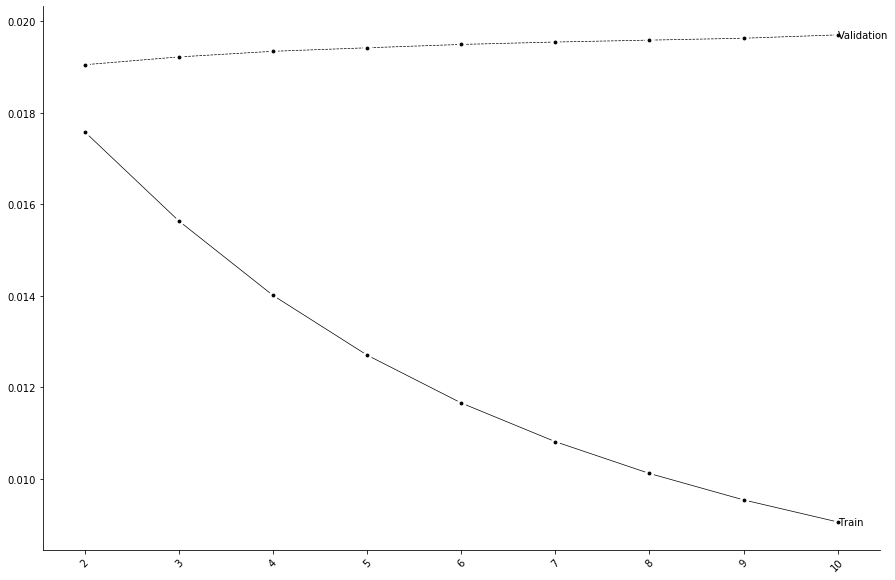

In [121]:
#Get the new dosage variables. 
train_mult_dose_time = train_x_pca_mult_fact_2_dose.drop(['cp_dose'], axis = 1).copy()
test_mult_dose_time = test_x_pca_mult_fact_2_dose.drop(['cp_dose'], axis = 1).copy()

mask_dose = train_mult_dose_time.columns.str.contains('^mult_fact_2_')
dose_variables = train_mult_dose_time.loc[:,mask_dose].columns 

#multiply by duration
for col in dose_variables:
    train_mult_dose_time['dose_time_' + col] = train_mult_dose_time[col] * (train_mult_dose_time['cp_time']/24)

for col in dose_variables:
    test_mult_dose_time['dose_time_' + col] = test_mult_dose_time[col] * (test_mult_dose_time['cp_time']/24)

train_mult_dose_time = train_mult_dose_time.drop(['cp_time'], axis = 1)
test_mult_dose_time = test_mult_dose_time.drop(['cp_time'], axis = 1)

train_mult_dose_time = train_mult_dose_time.drop(dose_variables, axis = 1)
test_mult_dose_time = test_mult_dose_time.drop(dose_variables, axis = 1)  
    
    
#Modeling with PCA 
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss

train_x_lgbm = train_mult_dose_time.copy()
test_x_lgbm = test_mult_dose_time.copy()
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_aux_50_10_dose_time.csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_hp_50_10_dose_time.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_lgbm.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_lgbm, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_lgbm)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_lgbm)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_lgbm)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Plotting tree:


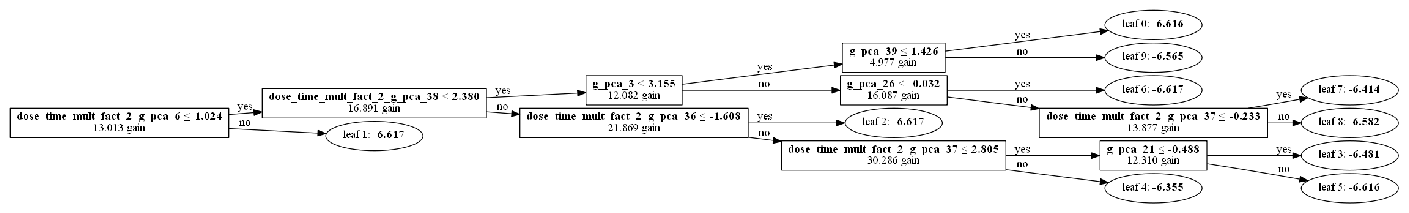

In [125]:
graph = lgb.create_tree_digraph(model)
graph.render(view=True)

print('Plotting tree:')
ax = lgb.plot_tree(model, figsize=(25, 30), show_info=['split_gain'])
plt.show()

We did not achieve a lower log loss, but lightGBM algorithm gave a higher priority to these new variables, so lets use them in the future.

Now lets make varibles in the format of X_i*X_j.


0.2697
Elapsed: 00:32:34
Total run time: 02:00:45
Time to finish: 01:28:11


0.5394
Elapsed: 01:10:01
Total run time: 02:09:48
Time to finish: 00:59:47


0.8091
Elapsed: 01:50:58
Total run time: 02:17:09
Time to finish: 00:26:11


Smallest log loss: 0.019
Smallest log loss parameter: 2.0


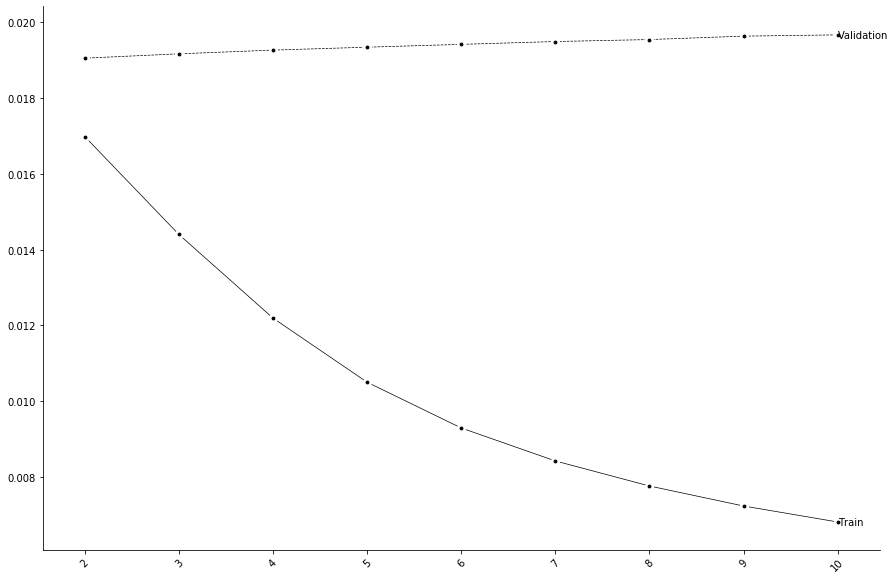

In [45]:
def xi_xj(db_in):
    mask_comp_g = db_in.columns.str.contains('^g_pca_[1-9]?[0-9]')
    g_components_db = db_in.loc[:,mask_comp_g].copy()
    g_components_columns = g_components_db.columns

    mask_comp_c = db_in.columns.str.contains('^c_pca_[1-9]?[0-9]')
    c_components_db = db_in.loc[:,mask_comp_c].copy()
    c_components_columns = c_components_db.columns

    for i in range(len(g_components_columns)):
        col_i = g_components_columns[i]
        for j in range(i, len(g_components_columns)):
            col_j = g_components_columns[j]
            g_components_db[col_i + '_mult_' + col_j] = g_components_db[col_i]*g_components_db[col_j]

    for i in range(len(c_components_columns)):
        col_i = c_components_columns[i]
        for j in range(i, len(c_components_columns)):
            col_j = c_components_columns[j]
            c_components_db[col_i + '_mult_' + col_j] = c_components_db[col_i]*c_components_db[col_j]

    #Drop overlapping columns
    g_components_db = g_components_db.drop(g_components_columns, axis = 1)
    c_components_db = c_components_db.drop(c_components_columns, axis = 1)

    db_out = db_in.join(g_components_db)
    db_out = db_out.join(c_components_db)
    return db_out



n_components_g = 50
n_components_c = 10
train_x_pca = PCA_validation_variables(train_x, n_components_g, n_components_c)
test_x_pca = PCA_validation_variables(test_x, n_components_g, n_components_c)


train_xi_xj_pca = xi_xj(train_x_pca)
test_xi_xj_pca = xi_xj(test_x_pca)

#Modeling with PCA 
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss

train_x_lgbm = train_xi_xj_pca.copy()
test_x_lgbm = test_xi_xj_pca.copy()
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_aux_50_10_xi_xj.csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_hp_50_10_xi_xj.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_lgbm.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_lgbm, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_lgbm)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_lgbm)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_lgbm)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Plotting tree:


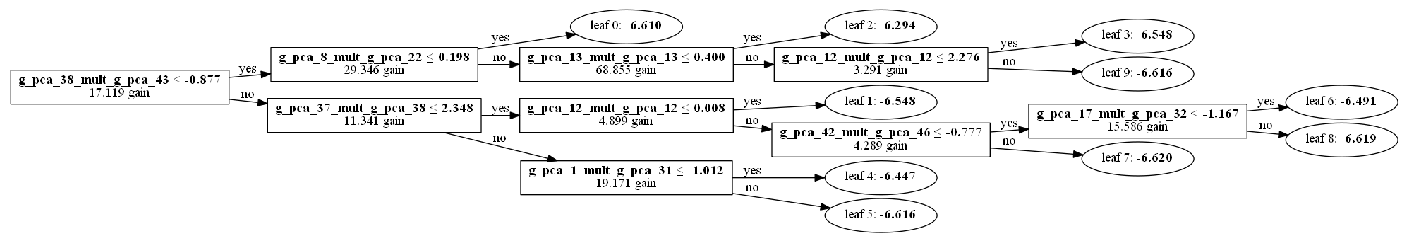

In [60]:
graph = lgb.create_tree_digraph(model, name = 'log_loss_num_leaves_with_pca_aux_50_10_xi_xj')
graph.render(view=True)

print('Plotting tree:')
ax = lgb.plot_tree(model, figsize=(25, 30), show_info=['split_gain'])
plt.show()

Again we did not achieve any logo loss gain but the new variables were used.\
Lets use these variables and the dose multiplied by time variables together.


0.2697
Elapsed: 00:32:47
Total run time: 02:01:33
Time to finish: 01:28:46


0.5394
Elapsed: 01:10:54
Total run time: 02:11:27
Time to finish: 01:00:33


0.8091
Elapsed: 01:52:46
Total run time: 02:19:22
Time to finish: 00:26:36


Smallest log loss: 0.0191
Smallest log loss parameter: 2.0


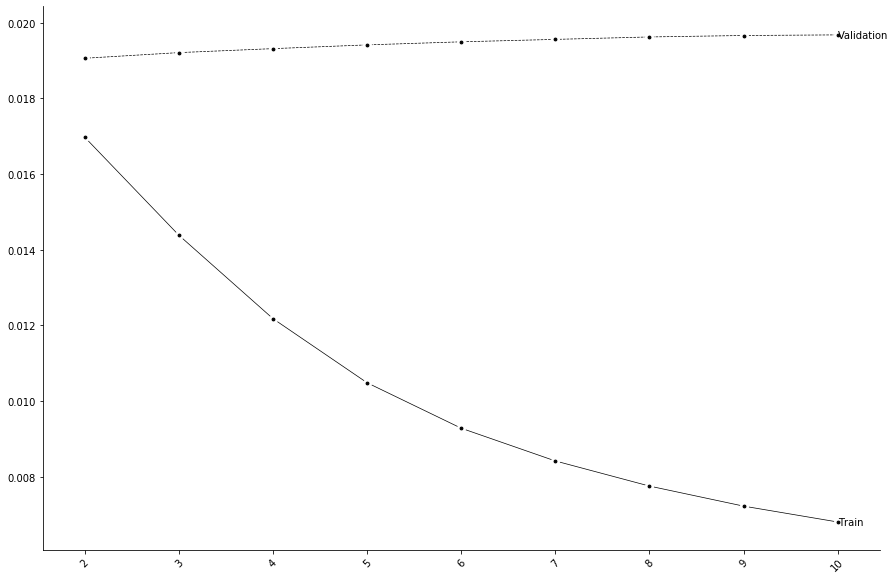

In [61]:
#Same code used to create the dose_time variables.
n_components_g = 50
n_components_c = 10
train_x_pca = PCA_validation_variables(train_x, n_components_g, n_components_c)
test_x_pca = PCA_validation_variables(test_x, n_components_g, n_components_c)

mask_g_c = train_x_pca.columns.str.contains('^g_*|^c_')
g_c_variables = train_x_pca.loc[:,mask_g_c].columns

train_x_pca_mult_fact_2_dose = train_x_pca.copy()
for col in g_c_variables:
    train_x_pca_mult_fact_2_dose['dose_fact_2_' + col] = train_x_pca_mult_fact_2_dose.apply(
        lambda row: row[col] if row['cp_dose'] == 2 else row[col] * 2, axis = 1)
    
test_x_pca_mult_fact_2_dose = test_x_pca.copy()
for col in g_c_variables:    
    test_x_pca_mult_fact_2_dose['dose_fact_2_' + col] = test_x_pca_mult_fact_2_dose.apply(
        lambda row: row[col] if row['cp_dose'] == 2 else row[col] * 2, axis = 1)
    
train_mult_dose_time = train_x_pca_mult_fact_2_dose.drop(['cp_dose'], axis = 1).copy()
test_mult_dose_time = test_x_pca_mult_fact_2_dose.drop(['cp_dose'], axis = 1).copy()

mask_dose = train_mult_dose_time.columns.str.contains('^dose_fact_2_')
dose_variables = train_mult_dose_time.loc[:,mask_dose].columns 

#multiply by duration
for col in dose_variables:
    train_mult_dose_time['time_' + col] = train_mult_dose_time[col] * (train_mult_dose_time['cp_time']/24)

for col in dose_variables:
    test_mult_dose_time['time_' + col] = test_mult_dose_time[col] * (test_mult_dose_time['cp_time']/24)

train_mult_dose_time = train_mult_dose_time.drop(['cp_time'], axis = 1)
test_mult_dose_time = test_mult_dose_time.drop(['cp_time'], axis = 1)

train_mult_dose_time = train_mult_dose_time.drop(dose_variables, axis = 1)
test_mult_dose_time = test_mult_dose_time.drop(dose_variables, axis = 1)

#Get Xi_Xj variables
mask_Xi_Xj = train_xi_xj_pca.columns.str.contains('_mult_')
train_Xi_Xj_variables = train_xi_xj_pca.loc[:,mask_Xi_Xj]
test_Xi_Xj_variables = test_xi_xj_pca.loc[:,mask_Xi_Xj]

#Join everything
train_dose_time_Xi_Xj = train_mult_dose_time.join(train_Xi_Xj_variables)
test_dose_time_Xi_Xj = test_mult_dose_time.join(test_Xi_Xj_variables)



#Modeling with PCA 
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss

train_x_lgbm = train_dose_time_Xi_Xj.copy()
test_x_lgbm = test_dose_time_Xi_Xj.copy()
save_file_aux = path_holdout + "log_loss_num_leaves_with_pca_aux_50_10_dose_time_Xi_Xj.csv"
save_file_final = path_holdout + "log_loss_num_leaves_with_pca_hp_50_10_dose_time_Xi_Xj.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "is_unbalance": False,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter,
                "min_data_in_leaf": 425,
#                 "max_depth": 4
            }

            features = train_x_lgbm.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x_lgbm, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x_lgbm)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x_lgbm)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x_lgbm)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Plotting tree:


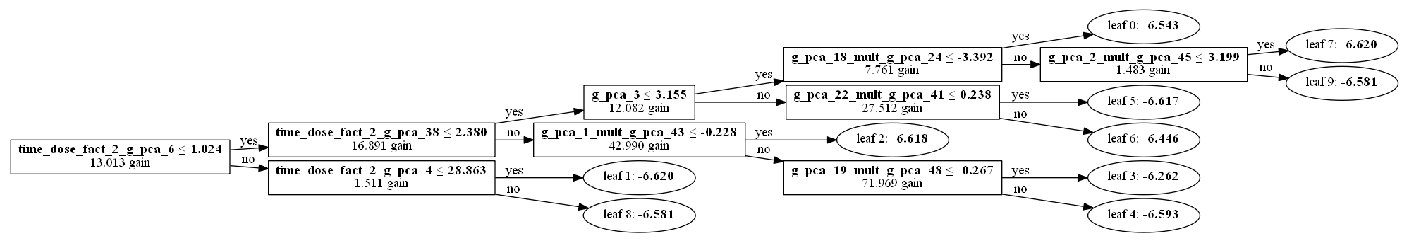

In [62]:
graph = lgb.create_tree_digraph(model, name = 'log_loss_num_leaves_with_pca_aux_50_10_dose_time_Xi_Xj')
graph.render(view=True)

print('Plotting tree:')
ax = lgb.plot_tree(model, figsize=(25, 30), show_info=['split_gain'])
plt.show()

We were not able to find a better model, but we found several new variables.\
If we want a lower log loss we need to change our base model, maybe a Feedforward neural network will be able to use all these new variables.